# Toronto Streetscore - CNN with Keras

In [2]:
import numpy as np 
import pandas as pd 
import os, sys
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow
import gc

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

from keras import layers
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Sequential, Model, load_model, model_from_yaml
from keras.optimizers import SGD
from keras.constraints import maxnorm

import keras.backend as K
from keras.models import Sequential

import lime
from lime import lime_image

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)


Using TensorFlow backend.


In [3]:
# importing the Boston streetscore data for training
boston_df = pd.read_csv("boston/boston_image_with_target.csv")
boston_df.rename(columns = {'_file':'Image_Id'}, inplace = True)
train_df = boston_df [["Image_Id", "safety"]]
train_df.head()

,Image_Id,safety
0,gsv_0.jpg,1
1,gsv_1.jpg,1
2,gsv_2.jpg,1
3,gsv_3.jpg,1
4,gsv_4.jpg,1


In [4]:
train_df.safety.value_counts().head()

0    10821
1     9083
Name: safety, dtype: int64

In [5]:
# this will be used to preprocess the datasets
def prepareImages(data, m, dataset, city):
    print("Preparing images")
    X = np.zeros((m, 100, 100, 3))
    count = 0
    
    for fig in data['Image_Id']:
        #load images into images of size 100x100x3
        img = image.load_img(city+"/"+dataset+"/"+fig, target_size=(100, 100, 3))
        x = image.img_to_array(img)
        x = preprocess_input(x)

        X[count] = x
        if (count%500 == 0):
            print("Processing image: ", count+1, ", ", fig)
        count += 1
    
    return X

In [6]:
# this will be used to generate labels for the training set
def prepare_labels(y):
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    # print(integer_encoded)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    # print(onehot_encoded)#

    y = onehot_encoded
    # print(y.shape)
    return y, label_encoder

In [7]:
# This chunk of code was added to resolve the error "OSError: image file is truncated" in the below cell
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [8]:
# now the training data will be imported
X = prepareImages(train_df, train_df.shape[0], "image", "boston")
X /= 255

Preparing images
Processing image:  1 ,  gsv_0.jpg
Processing image:  501 ,  gsv_502.jpg
Processing image:  1001 ,  gsv_1002.jpg
Processing image:  1501 ,  gsv_1504.jpg
Processing image:  2001 ,  gsv_2005.jpg
Processing image:  2501 ,  gsv_2505.jpg
Processing image:  3001 ,  gsv_3005.jpg
Processing image:  3501 ,  gsv_3506.jpg
Processing image:  4001 ,  gsv_4006.jpg
Processing image:  4501 ,  gsv_4508.jpg
Processing image:  5001 ,  gsv_5008.jpg
Processing image:  5501 ,  gsv_5508.jpg
Processing image:  6001 ,  gsv_6008.jpg
Processing image:  6501 ,  gsv_6510.jpg
Processing image:  7001 ,  gsv_7011.jpg
Processing image:  7501 ,  gsv_7514.jpg
Processing image:  8001 ,  gsv_8014.jpg
Processing image:  8501 ,  gsv_8514.jpg
Processing image:  9001 ,  gsv_9016.jpg
Processing image:  9501 ,  gsv_9516.jpg
Processing image:  10001 ,  gsv_10018.jpg
Processing image:  10501 ,  gsv_10521.jpg
Processing image:  11001 ,  gsv_11023.jpg
Processing image:  11501 ,  gsv_11524.jpg
Processing image:  1200

In [9]:
y, label_encoder = prepare_labels(train_df['safety'])

/home/ndurai2006/.local/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [10]:
# the CNN will now be defined
model = Sequential()

model.add(Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0', input_shape = (100, 100, 3)))

model.add(BatchNormalization(axis = 3, name = 'bn0'))
model.add(Activation('relu'))

model.add(MaxPooling2D((2, 2), name='max_pool'))
model.add(Conv2D(64, (3, 3), strides = (1,1), name="conv1"))
model.add(Activation('relu'))
model.add(AveragePooling2D((3, 3), name='avg_pool'))

model.add(Flatten())
model.add(Dense(500, activation="relu", name='rl'))
model.add(Dropout(0.8))
model.add(Dense(y.shape[1], kernel_initializer='normal', activation='softmax', kernel_constraint=maxnorm(3), name='sm'))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
# sgd = SGD(lr=0.1, momentum=0.9, decay=0.0, nesterov=False)
# model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv0 (Conv2D)               (None, 94, 94, 32)        4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 94, 94, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 94, 94, 32)        0         
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 47, 47, 32)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 45, 45, 64)        18496     
_________________________________________________________________
activation_2 (Activat

In [11]:
X.shape

(19904, 100, 100, 3)

In [12]:
y.shape

(19904, 2)

In [13]:
# this will train the CNN
history = model.fit(X, y, validation_split=0.2, epochs=50, batch_size=100, verbose=1)
gc.collect()

Instructions for updating:
Use tf.cast instead.
Train on 15923 samples, validate on 3981 samples
Epoch 1/50
15923/15923 [==============================] - 20s 1ms/step - loss: 0.7191 - acc: 0.6101 - val_loss: 0.6820 - val_acc: 0.6436
Epoch 2/50
15923/15923 [==============================] - 16s 980us/step - loss: 0.6069 - acc: 0.6707 - val_loss: 0.6826 - val_acc: 0.6353
Epoch 3/50
15923/15923 [==============================] - 16s 980us/step - loss: 0.5968 - acc: 0.6869 - val_loss: 0.6828 - val_acc: 0.6358
Epoch 4/50
15923/15923 [==============================] - 16s 982us/step - loss: 0.5837 - acc: 0.6977 - val_loss: 0.6541 - val_acc: 0.6606
Epoch 5/50
15923/15923 [==============================] - 16s 981us/step - loss: 0.5755 - acc: 0.6972 - val_loss: 0.6943 - val_acc: 0.6333
Epoch 6/50
15923/15923 [==============================] - 16s 983us/step - loss: 0.5682 - acc: 0.7082 - val_loss: 0.6330 - val_acc: 0.6709
Epoch 7/50
15923/15923 [==============================] - 16s 982us/ste

67

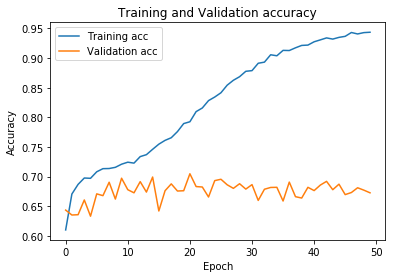

In [14]:
# This will plot the accuracy of the CNN on the training/validation set after each epoch
plt.plot(history.history['acc'], label='Training acc')
plt.plot(history.history['val_acc'], label='Validation acc')
plt.legend()
plt.title('Training and Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

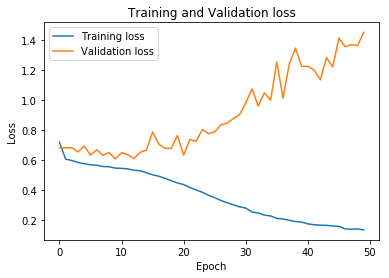

In [15]:
# This will plot the loss on the training and validation set after each epoch
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('Training and Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [16]:
# importing the Toronto data for testing the model
toronto_md = pd.read_json("toronto/metadata/metadata.json")
toronto_md.rename(columns = {'_file':'Image_Id'}, inplace = True)
toronto_md.head()

,Image_Id,copyright,date,location,pano_id,status
0,gsv_0.jpg,© Google,2018-07-01,"{'lat': 43.6814075014274, 'lng': -79.444445154...",aLRQFLoboL6papa2qE1Veg,OK
1,gsv_1.jpg,© Google,2018-08-01,"{'lat': 43.7488349459349, 'lng': -79.492156396...",hwo_vjTqlVcqF-my9fjVhw,OK
2,gsv_2.jpg,© Google,2018-08-01,"{'lat': 43.75852320755994, 'lng': -79.18330303...",1yc7mFQX1OGCMh2n9OvtRQ,OK
3,gsv_3.jpg,© Google,2018-08-01,"{'lat': 43.64732825618856, 'lng': -79.40845388...",hHP4wWeB0Ak1eqRV6ncfhg,OK
4,gsv_4.jpg,© Google,2018-08-01,"{'lat': 43.7604919, 'lng': -79.1795913}",bw_AvWlyXIOe2rV39MLNqQ,OK


In [17]:
test_df = toronto_md[["Image_Id"]]
test_df.head()

,Image_Id
0,gsv_0.jpg
1,gsv_1.jpg
2,gsv_2.jpg
3,gsv_3.jpg
4,gsv_4.jpg


In [18]:
test_df["Image_Id"].isna().sum()

66

In [19]:
test_df = test_df.dropna()

In [20]:
test_df["Image_Id"].isna().sum()

0

In [21]:
# this will preprocess the test data
X = prepareImages(test_df, test_df.shape[0], "image", "toronto")
X /= 255

Preparing images
Processing image:  1 ,  gsv_0.jpg
Processing image:  501 ,  gsv_512.jpg
Processing image:  1001 ,  gsv_1028.jpg
Processing image:  1501 ,  gsv_1541.jpg
Processing image:  2001 ,  gsv_2066.jpg


In [22]:
# now the labels for the test data will be generated 
predictions = model.predict(np.array(X), verbose=1)

2034/2034 [==============================] - 1s 528us/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

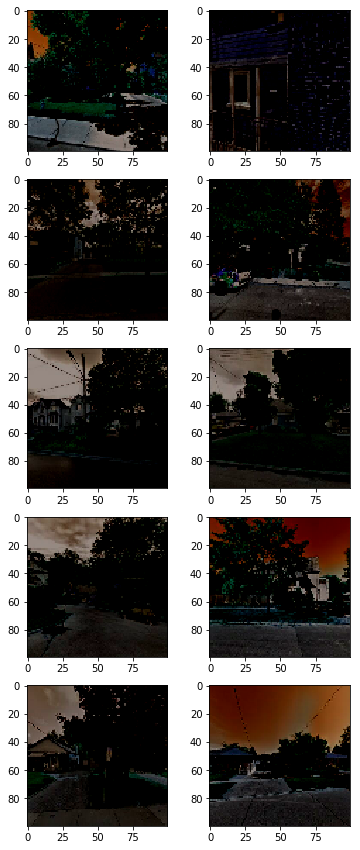

In [23]:
%matplotlib inline
xs = X[100:110]
ys = y[100:110]

n_cols = 2
n_rows = int(len(xs)/2)
plt.figure(figsize=(3*n_cols, 3*n_rows))
for i in range(len(xs)):
    plt.subplot(5, 2, i+1)
    plt.imshow(xs[i].reshape(100,100,3), cmap='gray')

In [24]:
# Persist the mode
model_yaml = model.to_yaml()
with open("model_keras_cnn_v3c.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights("model_keras_cnn_v3c.h5")
print("Saved model to disk")
yaml_file.close()

Saved model to disk


In [33]:
from keras.models import Sequential, Model, load_model, model_from_yaml
# Load the model
yaml_file = open('model_keras_cnn_v3c.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
loaded_model = model_from_yaml(loaded_model_yaml)
# load weights into new model
loaded_model.load_weights("model_keras_cnn_v3c.h5")
print("Loaded model from disk")

Loaded model from disk


In [34]:
### Predictions on the selected input
input_x = X[100:110]
#input_y = y[100:110]
sample_prediction = loaded_model.predict_classes(input_x)
print(sample_prediction)

[1 1 1 1 1 1 1 1 1 0]


In [35]:
explainer = lime_image.LimeImageExplainer()

In [36]:
import skimage
print(skimage.__version__)

0.15.0


In [38]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(input_x[0], loaded_model.predict, top_labels=2, num_samples=1000)

CPU times: user 1.07 s, sys: 48 ms, total: 1.12 s
Wall time: 1.31 s


In [39]:
from skimage.segmentation import mark_boundaries

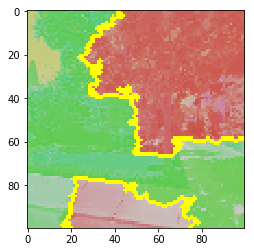

In [46]:
temp, mask = explanation.get_image_and_mask(sample_prediction[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [47]:
%%time
explanation = explainer.explain_instance(input_x[1], loaded_model.predict, top_labels=2, num_samples=1000)

CPU times: user 1.06 s, sys: 100 ms, total: 1.16 s
Wall time: 1.34 s


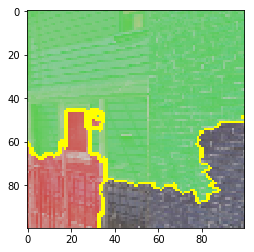

In [48]:
temp, mask = explanation.get_image_and_mask(sample_prediction[1], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [49]:
%%time
explanation = explainer.explain_instance(input_x[2], loaded_model.predict, top_labels=2, num_samples=1000)

CPU times: user 1.06 s, sys: 60 ms, total: 1.12 s
Wall time: 1.32 s


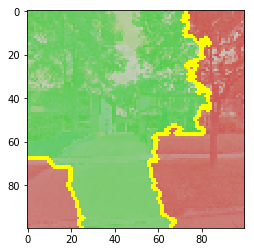

In [50]:
temp, mask = explanation.get_image_and_mask(sample_prediction[2], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [51]:
%%time
explanation = explainer.explain_instance(input_x[3], loaded_model.predict, top_labels=2, num_samples=1000)

CPU times: user 1.04 s, sys: 92 ms, total: 1.14 s
Wall time: 1.34 s


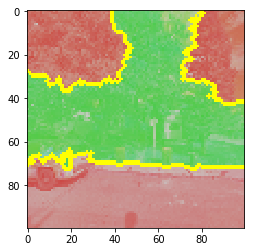

In [52]:
temp, mask = explanation.get_image_and_mask(sample_prediction[3], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [53]:
%%time
explanation = explainer.explain_instance(input_x[4], loaded_model.predict, top_labels=2, num_samples=1000)

CPU times: user 1.04 s, sys: 72 ms, total: 1.12 s
Wall time: 1.32 s


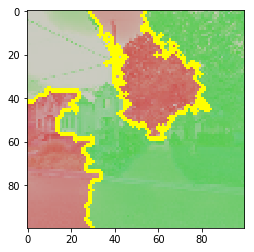

In [54]:
temp, mask = explanation.get_image_and_mask(sample_prediction[4], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [55]:
%%time
explanation = explainer.explain_instance(input_x[5], loaded_model.predict, top_labels=2, num_samples=1000)

CPU times: user 1.08 s, sys: 52 ms, total: 1.13 s
Wall time: 1.32 s


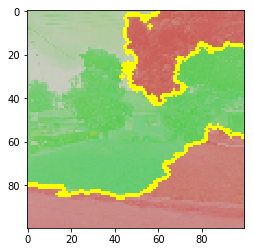

In [56]:
temp, mask = explanation.get_image_and_mask(sample_prediction[5], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [57]:
%%time
explanation = explainer.explain_instance(input_x[6], loaded_model.predict, top_labels=2, num_samples=1000)

CPU times: user 1.06 s, sys: 48 ms, total: 1.11 s
Wall time: 1.3 s


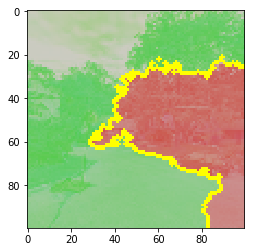

In [58]:
temp, mask = explanation.get_image_and_mask(sample_prediction[6], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [59]:
%%time
explanation = explainer.explain_instance(input_x[7], loaded_model.predict, top_labels=2, num_samples=1000)

CPU times: user 1.03 s, sys: 76 ms, total: 1.11 s
Wall time: 1.31 s


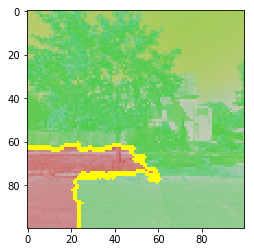

In [60]:
temp, mask = explanation.get_image_and_mask(sample_prediction[7], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [61]:
%%time
explanation = explainer.explain_instance(input_x[8], loaded_model.predict, top_labels=2, num_samples=1000)

CPU times: user 1.04 s, sys: 60 ms, total: 1.1 s
Wall time: 1.29 s


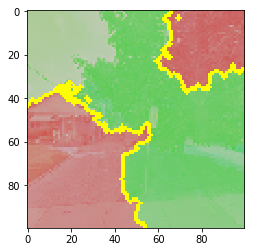

In [62]:
temp, mask = explanation.get_image_and_mask(sample_prediction[8], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [63]:
%%time
explanation = explainer.explain_instance(input_x[9], loaded_model.predict, top_labels=2, num_samples=1000)

CPU times: user 1.04 s, sys: 52 ms, total: 1.1 s
Wall time: 1.28 s


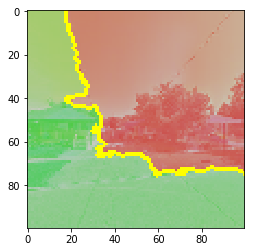

In [64]:
temp, mask = explanation.get_image_and_mask(sample_prediction[9], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))